# MP2 二阶梯度：非安全做法

这份文档将会实现 MP2 二阶梯度；我们将从 MP2 一阶梯度的公式出发，进行最初步的推导，得到可以程序化的二阶 MP2 解析梯度。但这份文档并不关注解法的合理性，即允许 $U_{ij}^{A_t}$, $U_{ab}^{A_t}$, $U_{ai}^{A_t B_s}$ 等不安全项出现。

In [1]:
import numpy as np
from pyscf import scf, gto, lib, grad, hessian, dft, mp
import pyscf.hessian.rks
import pyscf.grad.rks
from functools import partial
import pickle

from utilities import val_from_fchk, NumericDiff
from hessian import HFHelper, GGAHelper

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.einsum_path = partial(np.einsum_path, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(6, linewidth=150, suppress=True)

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

nmo = nao = mol.nao
natm = mol.natm
nocc = mol.nelec[0]
nvir = nmo - nocc
so = slice(0, nocc)
sv = slice(nocc, nmo)
sa = slice(0, nmo)

In [3]:
# We use U_2 in this document
# Pre-generate some code here will make later work quicker
# But these operations are numerical-unstable or memory consuming
hfh = HFHelper(mol)
hfh.U_2_vo
hfh.eri0_mo
hfh.eri1_mo
hfh.eri2_mo
hfh

/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:366: UserWarning: U_1: Generating total U matrix should be considered as numerical unstable!
  warnings.warn("U_1: Generating total U matrix should be considered as numerical unstable!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:229: UserWarning: eri0_mo: ERI AO -> MO is quite expensive!
  warnings.warn("eri0_mo: ERI AO -> MO is quite expensive!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:222: UserWarning: eri0_ao: ERI should not be stored in memory! Consider J/K engines!
  warnings.warn("eri0_ao: ERI should not be stored in memory! Consider J/K engines!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:279: UserWarning: eri1_mo: 4-idx tensor ERI should be not used!
  warnings.warn("eri1_mo: 4-idx tensor ERI should be not used!")
/share/home/zyzhu/Git-Repo/Python-xDH/pyxdh/hessian/hf_helper.py:272: UserWarning: eri1_ao: 4-idx tensor ERI should be not used!
  w

## MP2 二阶梯度：参考值

在与 MP2 Hessian 相关的 [资源文件夹](include/mp2_hess) 下，我们可以拿通过 PySCF 的 MP2 梯度对象进行数值导数的结果与 Gaussian 提供的 MP2 Hessian 结果进行比对：

In [4]:
with open("include/mp2_hess/mp2_hess_num.dat", "rb") as f:
    hess_mp2_pyscf_num = pickle.load(f)["grad_mp2_diff"]

d_hess = mol.natm * 3
np.allclose(
    hess_mp2_pyscf_num.swapaxes(1, 2).reshape(d_hess, d_hess)[np.tril_indices(d_hess)],
    val_from_fchk("Cartesian Force Constants", "include/mp2_hess/mp2_hess.fchk"),
    atol=1e-7
)

True

上述的梯度值是 MP2 总能量的二阶梯度；因此，MP2 相关能的二阶梯度的参考值可以通过下述方法生成：

In [5]:
g_array = val_from_fchk("Cartesian Force Constants", "include/mp2_hess/mp2_hess.fchk")
hess_mp2_gaussian = np.zeros((d_hess, d_hess))
p = 0
for d1 in range(d_hess):
    for d2 in range(d1 + 1):
        hess_mp2_gaussian[d1][d2] = hess_mp2_gaussian[d2][d1] = g_array[p]
        p += 1
hess_mp2_gaussian = hess_mp2_gaussian.reshape((natm, 3, natm, 3)).swapaxes(1, 2)

In [6]:
hess_mp2_ref = hess_mp2_gaussian - hfh.scf_hess.kernel()

## MP2 一阶梯度：重新表述

在我们继续 MP2 二阶梯度前，我们先简要回顾一下 MP2 的一阶梯度。我们除了要定义一些重要的中间变量之外，也需要将一阶梯度的表达式重新塑造成容易推导二阶梯度的表达形式上。

### 重要变量定义

In [7]:
mp2_eng = mp.MP2(hfh.scf_eng)
mp2_eng.kernel()[0]
mp2_grad = grad.mp2.Gradients(mp2_eng)
mp2_grad.kernel()

array([[-0.102293,  0.014371,  0.031588],
       [ 0.008573,  0.75439 , -0.009366],
       [ 0.087807,  0.00276 ,  0.014487],
       [ 0.005914, -0.77152 , -0.036708]])

In [8]:
%%capture

e, eo, ev = hfh.e, hfh.eo, hfh.ev
C, Co, Cv = hfh.C, hfh.Co, hfh.Cv
D = hfh.D
eri0_mo = hfh.eri0_mo
eri1_mo = hfh.eri1_mo
eri2_mo = hfh.eri2_mo

F_1_mo = hfh.F_1_mo
S_1_mo = hfh.S_1_mo
U_1 = hfh.U_1
U_1_vo = hfh.U_1_vo
U_2_vo = hfh.U_2_vo
B_1 = hfh.B_1
B_2 = hfh._get_B_2()
Ax0_Core = hfh.Ax0_Core

D_iajb = lib.direct_sum("i - a + j - b", hfh.eo, hfh.ev, hfh.eo, hfh.ev)

在后续计算中，我们还会使用到全轨道的 $U_{pq}^{A_t B_s}$；在这里，我们用类似于生成 $U_{pq}^{A_t}$ 的方式生成该张量：

In [9]:
D_pq = - lib.direct_sum("p - q -> pq", e, e) + 1e-300
U_2 = np.zeros((natm, natm, 3, 3, nmo, nmo))
U_2[:, :, :, :, sv, so] = U_2_vo
U_2[:, :, :, :, so, sv] = - hfh.Xi_2[:, :, :, :, so, sv] - U_2[:, :, :, :, sv, so].swapaxes(-1, -2)
U_2[:, :, :, :, so, so] = (Ax0_Core(so, so, sv, so)(U_2_vo) + B_2[:, :, :, :, so, so]) / D_pq[so, so]
U_2[:, :, :, :, sv, sv] = (Ax0_Core(sv, sv, sv, so)(U_2_vo) + B_2[:, :, :, :, sv, sv]) / D_pq[sv, sv]
for p in range(nmo):
    U_2[:, :, :, :, p, p] = - hfh.Xi_2[:, :, :, :, p, p] / 2
U_2 -= (U_2 + U_2.swapaxes(-1, -2) + hfh.Xi_2) / 2
U_2 -= (U_2 + U_2.swapaxes(-1, -2) + hfh.Xi_2) / 2

### 重塑表达式

我们现在将 MP2 二阶梯度的表达式重新表述，方便以后的项求导。

方才用于验证生成矩阵和张量正确性的代码块中，用到的梯度公式是

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} = D_{pq}^\mathrm{MP2} F_{pq}^{A_t} + W_{pq}^\mathrm{MP2} S_{pq}^{A_t} + T_{ij}^{ab} (ia|jb)^{A_t}
$$

但上述公式不方便求导。我们采用以前提过的不安全的推导方法，重新推导 MP2 的一阶梯度；进而整理推导过程，为二阶梯度的推导作准备。

首先，我们指出，

$$
E_\mathrm{elec}^{\mathrm{MP2}} = T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab}
$$

但这种写法，在推导 $\frac{\partial}{\partial A_t} T_{ij}^{ab}$ 与 $\frac{\partial}{\partial A_t} t_{ij}^{ab}$ 会带来麻烦；因此，我们新定义以下记号 (类似于 Helgaker)：

* `g_mo`: $g_{pq}^{rs} = (pq|rs)$

* `G_mo`: $\tilde g_{pq}^{rs} = 2 g_{pq}^{rs} - g_{pq}^{sr}$

这只是出于公式与程序表达方便而写。$g_{pq}^{rs}$ 就是 `eri0_mo` 的表达式。同时，我们记分割

* `g_iajb`: $g_{ij}^{ab}$

* `G_iajb`: $\tilde g_{ij}^{ab}$

In [10]:
g_mo = eri0_mo
G_mo = 2 * g_mo - g_mo.swapaxes(-1, -3)
g_iajb = g_mo[so, sv, so, sv]
G_iajb = G_mo[so, sv, so, sv]

因此，

$$
E_\mathrm{elec}^{\mathrm{MP2}} = \tilde g_{ij}^{ab} g_{ij}^{ab} (D_{ij}^{ab})^{-1}
$$

In [11]:
np.allclose((g_iajb * G_iajb / D_iajb).sum(), mp2_eng.e_corr)

True

我们进而定义轨道能导数 (这个导数不区分 $\partial_{A_t}$ 或 $\partial_{A_t}^\mathrm{U}$)

* `e_1`: $\varepsilon_p^{A_t} = \frac{\partial}{\partial A_t} \varepsilon_p = B_{pp}^{A_t} + A_{pp, bj} U_{bj}^{A_t}$

* `eo_1, ev_1`: 占据与非占的分割

In [12]:
e_1 = (B_1 + Ax0_Core(sa, sa, sv, so)(U_1_vo)).diagonal(0, -1, -2)
eo_1, ev_1 = e_1[:, :, so], e_1[:, :, sv]

上述项的定义可以用于 $D_{ij}^{ab}$ 的导数中。我们可以通过对轨道能求梯度来验证上述解析轨道能梯度是否生成正确：

In [13]:
def mol_to_e_0(mol):
    scfh = HFHelper(mol)
    return scfh.e
e_1_num = NumericDiff(mol, mol_to_e_0).get_numdif()

In [14]:
np.allclose(e_1_num, e_1, rtol=1e-4)

True

同理，我们还可以定义轨道能的二阶导数：

* `e_2`: $\varepsilon_p^{A_t B_s} = \frac{\partial^2}{\partial A_t B_s} \varepsilon_p = B_{pp}^{A_t B_s} + A_{pp, bj} U_{bj}^{A_t B_s}$

* `eo_2, ev_2`: 占据与非占的分割

In [15]:
e_2 = (B_2 + Ax0_Core(sa, sa, sv, so)(U_2_vo)).diagonal(0, -1, -2)
eo_2, ev_2 = e_2[:, :, :, :, so], e_2[:, :, :, :, sv]

我们尽管也可以用数值方法验证上述的结果正确，但耗时较长。这里将验证的代码注释了。

In [16]:
# def mol_to_e_1(mol):
#     scfh = HFHelper(mol)
#     return (scfh.B_1 + scfh.Ax0_Core(sa, sa, sv, so)(scfh.U_1_vo)).diagonal(0, -1, -2)
# e_2_num = NumericDiff(mol, mol_to_e_1, deriv=2).get_numdif()

In [17]:
# np.allclose(e_2_num, e_2, atol=1e-5, rtol=5e-4)

由已知的定义，我们可以导出

* `pd_g_mo`: $\partial_{A_t} g_{ij}^{ab} = (ia|jb)^{A_t}$ (全轨道)

* `pdU_g_mo`: $\partial_{A_t}^\mathrm{U} g_{ij}^{ab} = g_{pj}^{ab} U_{pi}^{A_t} + g_{ip}^{ab} U_{pj}^{A_t} + g_{ij}^{pb} U_{pa}^{A_t} + g_{ij}^{ap} U_{pb}^{A_t}$ (全轨道)

* `pdA_g_mo`: $\frac{\partial}{\partial A_t} g_{ij}^{ab} = (\partial_{A_t} + \partial_{A_t}^\mathrm{U}) g_{ij}^{ab} = (ia|jb)^{A_t}$ (全轨道)

* `pdA_G_mo`: $\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab} = 2 \frac{\partial}{\partial A_t} g_{ij}^{ab} - \frac{\partial}{\partial A_t} g_{ij}^{ba}$ (全轨道)

* `pdA_D_iajb`: $\frac{\partial}{\partial A_t} D_{ij}^{ab} = \varepsilon_i^{A_t} - \varepsilon_a^{A_t} + \varepsilon_j^{A_t} - \varepsilon_b^{A_t}$

以及占据-非占-占据-非占的分割 `pdA_g_iajb`, `pdA_G_iajb`：

In [18]:
pd_g_mo = eri1_mo
pdU_g_mo = (
    + np.einsum("pjkl, Atpi -> Atijkl", g_mo, U_1)
    + np.einsum("ipkl, Atpj -> Atijkl", g_mo, U_1)
    + np.einsum("ijpl, Atpk -> Atijkl", g_mo, U_1)
    + np.einsum("ijkp, Atpl -> Atijkl", g_mo, U_1)
)
pdA_g_mo = pd_g_mo + pdU_g_mo

pdA_G_mo = 2 * pdA_g_mo - pdA_g_mo.swapaxes(-1, -3)

pdA_g_iajb = pdA_g_mo[:, :, so, sv, so, sv]
pdA_G_iajb = pdA_G_mo[:, :, so, sv, so, sv]

pdA_D_iajb = (
    + eo_1[:, :, :, None, None, None]
    - ev_1[:, :, None, :, None, None]
    + eo_1[:, :, None, None, :, None]
    - ev_1[:, :, None, None, None, :]
)

<div class="alert alert-info">

**提醒**

我们曾经经常使用 `pyscf.lib.direct_sum` 来执行直和计算；但 PySCF 的直和在维度增大时会出现过大的内存占用。因此，这里使用相对不太直观的 ndarray Broadcasting 方法计算直和。

</div>

因此，MP2 的梯度可以写作以下表达式：

$$
E_\mathrm{elec}^{\mathrm{MP2}, A_t} =
(\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab}) g_{ij}^{ab} (D_{ij}^{ab})^{-1}
+ \tilde g_{ij}^{ab} (\frac{\partial}{\partial A_t} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
- \tilde g_{ij}^{ab} g_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
$$

In [19]:
grad_mp2_ref = mp2_grad.de - hfh.scf_grad.kernel()
np.allclose(
    + np.einsum("Atiajb, iajb, iajb -> At", pdA_G_iajb, g_iajb, 1 / D_iajb)
    + np.einsum("iajb, Atiajb, iajb -> At", G_iajb, pdA_g_iajb, 1 / D_iajb)
    - np.einsum("iajb, iajb, Atiajb, iajb -> At", G_iajb, g_iajb, pdA_D_iajb, 1 / D_iajb**2)
    ,
    grad_mp2_ref
)

True

## MP2 二阶梯度：非安全初步实践

\begin{align}
E_\mathrm{elec}^{\mathrm{MP2}, A_t B_s} =
&
% First
% (\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab}) g_{ij}^{ab} (D_{ij}^{ab})^{-1}
+ (\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} \tilde g_{ij}^{ab}) g_{ij}^{ab} (D_{ij}^{ab})^{-1}
+ (\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab}) (\frac{\partial}{\partial B_s} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
- (\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab}) g_{ij}^{ab} (\frac{\partial}{\partial B_s} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
\\&
% Second
% \tilde g_{ij}^{ab} (\frac{\partial}{\partial A_t} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
+ (\frac{\partial}{\partial B_s} \tilde g_{ij}^{ab}) (\frac{\partial}{\partial A_t} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
+ \tilde g_{ij}^{ab} (\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
- \tilde g_{ij}^{ab} (\frac{\partial}{\partial A_t} g_{ij}^{ab}) (\frac{\partial}{\partial B_s} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
\\&
% Third
% \tilde g_{ij}^{ab} g_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
- (\frac{\partial}{\partial B_s} \tilde g_{ij}^{ab}) g_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
- \tilde g_{ij}^{ab} (\frac{\partial}{\partial B_s} g_{ij}^{ab}) (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
- \tilde g_{ij}^{ab} g_{ij}^{ab} (\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
+ 2 \tilde g_{ij}^{ab} g_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (\frac{\partial}{\partial B_s} D_{ij}^{ab}) (D_{ij}^{ab})^{-3}
\end{align}

在二阶梯度的生成中，我们还需要额外地生成分项 $\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} g_{ij}^{ab}$ 与 $\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} D_{ij}^{ab}$。后者的生成非常方便：

* `pdA_pdA_D_iajb`: $\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} D_{ij}^{ab}$

$$
\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} D_{ij}^{ab} = \varepsilon_i^{A_t B_s} - \varepsilon_a^{A_t B_s} + \varepsilon_j^{A_t B_s} - \varepsilon_b^{A_t B_s}
$$

In [20]:
pdA_pdA_D_iajb = (
    + eo_2[:, :, :, :, :, None, None, None]
    - ev_2[:, :, :, :, None, :, None, None]
    + eo_2[:, :, :, :, None, None, :, None]
    - ev_2[:, :, :, :, None, None, None, :]
)

但前者的生成需要一些功夫。我们先定义以下的小分项：

* `pdU_U_1`: $\partial_{A_t}^\mathrm{U} U_{pq}^{B_s}$

* `pd_pd_g_mo`: $\partial_{A_t} \partial_{B_s} g_{ij}^{ab}$

* `pdU_pd_g_mo`: $\partial_{A_t}^\mathrm{U} \partial_{B_s} g_{ij}^{ab}$

* `pd_pdU_g_mo`: $\partial_{A_t} \partial_{B_s}^\mathrm{U} g_{ij}^{ab} = \partial_{A_t}^\mathrm{U} \partial_{B_s} g_{ij}^{ab}$

* `pdU_pdU_g_mo`: $\partial_{A_t}^\mathrm{U} \partial_{B_s}^\mathrm{U} g_{ij}^{ab}$

$$
\partial_{A_t}^\mathrm{U} U_{pq}^{B_s} = \frac{\partial}{\partial A_t} U_{pq}^{B_s} = U_{pq}^{A_t B_s} - U_{pm}^{A_t} U_{mq}^{B_s}
$$

\begin{align}
\partial_{A_t} \partial_{B_s} g_{ij}^{ab} &= (ij|ab)^{A_t B_s}
\\
\partial_{A_t}^\mathrm{U} \partial_{B_s} g_{ij}^{ab} &=
(\partial_{A_t} g_{pj}^{ab}) U_{pi}^{B_s} +
(\partial_{A_t} g_{ip}^{ab}) U_{pj}^{B_s} +
(\partial_{A_t} g_{ij}^{pb}) U_{pa}^{B_s} +
(\partial_{A_t} g_{ij}^{ap}) U_{pb}^{B_s}
\\
\partial_{A_t}^\mathrm{U} \partial_{B_s}^\mathrm{U} g_{ij}^{ab} &=
(\partial_{A_t}^\mathrm{U} g_{pj}^{ab}) U_{pi}^{B_s} +
(\partial_{A_t}^\mathrm{U} g_{ip}^{ab}) U_{pj}^{B_s} +
(\partial_{A_t}^\mathrm{U} g_{ij}^{pb}) U_{pa}^{B_s} +
(\partial_{A_t}^\mathrm{U} g_{ij}^{ap}) U_{pb}^{B_s} +
\\&\quad
g_{pj}^{ab} (\partial_{A_t}^\mathrm{U} U_{pi}^{B_s}) + 
g_{ip}^{ab} (\partial_{A_t}^\mathrm{U} U_{pj}^{B_s}) + 
g_{ij}^{pb} (\partial_{A_t}^\mathrm{U} U_{pa}^{B_s}) + 
g_{ij}^{ap} (\partial_{A_t}^\mathrm{U} U_{pb}^{B_s})
\end{align}

In [21]:
pdU_U_1 = U_2 - np.einsum("Atpm, Bsmq -> ABtspq", U_1, U_1)
pd_pd_g_mo = eri2_mo
pdU_pd_g_mo = (
    # pd on g
    + np.einsum("Atpjkl, Bspi -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atipkl, Bspj -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atijpl, Bspk -> ABtsijkl", pd_g_mo, U_1)
    + np.einsum("Atijkp, Bspl -> ABtsijkl", pd_g_mo, U_1)
)
pd_pdU_g_mo = pdU_pd_g_mo.swapaxes(0, 1).swapaxes(2, 3)
pdU_pdU_g_mo = (
    # pdU on g * U
    + np.einsum("Atpjkl, Bspi -> ABtsijkl", pdU_g_mo, U_1)
    + np.einsum("Atipkl, Bspj -> ABtsijkl", pdU_g_mo, U_1)
    + np.einsum("Atijpl, Bspk -> ABtsijkl", pdU_g_mo, U_1)
    + np.einsum("Atijkp, Bspl -> ABtsijkl", pdU_g_mo, U_1)
    # g * pdU on U
    + np.einsum("pjkl, ABtspi -> ABtsijkl", g_mo, pdU_U_1)
    + np.einsum("ipkl, ABtspj -> ABtsijkl", g_mo, pdU_U_1)
    + np.einsum("ijpl, ABtspk -> ABtsijkl", g_mo, pdU_U_1)
    + np.einsum("ijkp, ABtspl -> ABtsijkl", g_mo, pdU_U_1)
)

我们应当能验证 $\partial_{A_t}^\mathrm{U} \partial_{B_s}^\mathrm{U} g_{ij}^{ab}$ 是关于 $(A_t, B_s)$ 对称的，即使从其等式右边来看并不那么显然：

In [22]:
np.allclose(pdU_pdU_g_mo, pdU_pdU_g_mo.swapaxes(0, 1).swapaxes(2, 3))

True

由此，可以定义分项

* `pdA_pdA_g_mo`: $\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} g_{ij}^{ab}$

* `pdA_pdA_G_mo`: $\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} \tilde g_{ij}^{ab}$

以及它们在占据-非占-占据-非占下的分割 `pdA_pdA_g_iajb`, `pdA_pdA_G_iajb`：

$$
\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} g_{ij}^{ab}
= \partial_{A_t} \partial_{B_s} g_{ij}^{ab} + \partial_{A_t}^\mathrm{U} \partial_{B_s} g_{ij}^{ab} + \partial_{A_t} \partial_{B_s}^\mathrm{U} g_{ij}^{ab} + \partial_{A_t}^\mathrm{U} \partial_{B_s}^\mathrm{U} g_{ij}^{ab}
$$

$$
\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} \tilde g_{ij}^{ab} = 2 \frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} g_{ij}^{ab} - \frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} g_{ij}^{ba}
$$

In [23]:
pdA_pdA_g_mo = pd_pd_g_mo + pd_pdU_g_mo + pdU_pd_g_mo + pdU_pdU_g_mo
pdA_pdA_G_mo = 2 * pdA_pdA_g_mo - pdA_pdA_g_mo.swapaxes(-1, -3)
pdA_pdA_g_iajb = pdA_pdA_g_mo[:, :, :, :, so, sv, so, sv]
pdA_pdA_G_iajb = pdA_pdA_G_mo[:, :, :, :, so, sv, so, sv]

由此，我们已经将计算 MP2 二阶梯度所必要的分项都得以生成。最后，我们列出非安全的 MP2 二阶梯度表达式：

\begin{align}
E_\mathrm{elec}^{\mathrm{MP2}, A_t B_s} =
&
% First
% (\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab}) g_{ij}^{ab} (D_{ij}^{ab})^{-1}
+ (\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} \tilde g_{ij}^{ab}) g_{ij}^{ab} (D_{ij}^{ab})^{-1}
+ (\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab}) (\frac{\partial}{\partial B_s} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
- (\frac{\partial}{\partial A_t} \tilde g_{ij}^{ab}) g_{ij}^{ab} (\frac{\partial}{\partial B_s} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
\\&
% Second
% \tilde g_{ij}^{ab} (\frac{\partial}{\partial A_t} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
+ (\frac{\partial}{\partial B_s} \tilde g_{ij}^{ab}) (\frac{\partial}{\partial A_t} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
+ \tilde g_{ij}^{ab} (\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} g_{ij}^{ab}) (D_{ij}^{ab})^{-1}
- \tilde g_{ij}^{ab} (\frac{\partial}{\partial A_t} g_{ij}^{ab}) (\frac{\partial}{\partial B_s} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
\\&
% Third
% \tilde g_{ij}^{ab} g_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
- (\frac{\partial}{\partial B_s} \tilde g_{ij}^{ab}) g_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
- \tilde g_{ij}^{ab} (\frac{\partial}{\partial B_s} g_{ij}^{ab}) (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
- \tilde g_{ij}^{ab} g_{ij}^{ab} (\frac{\partial}{\partial A_t} \frac{\partial}{\partial B_s} D_{ij}^{ab}) (D_{ij}^{ab})^{-2}
+ 2 \tilde g_{ij}^{ab} g_{ij}^{ab} (\frac{\partial}{\partial A_t} D_{ij}^{ab}) (\frac{\partial}{\partial B_s} D_{ij}^{ab}) (D_{ij}^{ab})^{-3}
\end{align}

In [24]:
hess_mp2 = (
    # Line 1
    + np.einsum("ABtsiajb, iajb, iajb -> ABts", pdA_pdA_G_iajb, g_iajb, 1 / D_iajb)
    + np.einsum("Atiajb, Bsiajb, iajb -> ABts", pdA_G_iajb, pdA_g_iajb, 1 / D_iajb)
    - np.einsum("Atiajb, iajb, Bsiajb, iajb -> ABts", pdA_G_iajb, g_iajb, pdA_D_iajb, 1 / D_iajb**2)
    # Line 2
    + np.einsum("Bsiajb, Atiajb, iajb -> ABts", pdA_G_iajb, pdA_g_iajb, 1 / D_iajb)
    + np.einsum("iajb, ABtsiajb, iajb -> ABts", G_iajb, pdA_pdA_g_iajb, 1 / D_iajb)
    - np.einsum("iajb, Atiajb, Bsiajb, iajb -> ABts", G_iajb, pdA_g_iajb, pdA_D_iajb, 1 / D_iajb**2)
    # Line 3
    - np.einsum("Bsiajb, iajb, Atiajb, iajb -> ABts", pdA_G_iajb, g_iajb, pdA_D_iajb, 1 / D_iajb**2)
    - np.einsum("iajb, Bsiajb, Atiajb, iajb -> ABts", G_iajb, pdA_g_iajb, pdA_D_iajb, 1 / D_iajb**2)
    - np.einsum("iajb, iajb, ABtsiajb, iajb -> ABts", G_iajb, g_iajb, pdA_pdA_D_iajb, 1 / D_iajb**2)
    + 2 * np.einsum("iajb, iajb, Atiajb, Bsiajb, iajb -> ABts", G_iajb, g_iajb, pdA_D_iajb, pdA_D_iajb, 1 / D_iajb**3)
)

我们可以验证上述计算结果与参考值非常接近，意味着我们正确地生成了 MP2 解析二阶梯度：

In [25]:
np.allclose(hess_mp2, hess_mp2_ref)

True

## XYG3 二阶梯度：非安全实现初步

这篇文档的最后，我们尝试用刚才的代码来生成 XYG3 的二阶梯度。参考值在下述的代码单元中生成。

In [26]:
with open("include/mp2_hess/xyg3_hess_num.dat", "rb") as f:
    hess_xyg3_num = pickle.load(f)["grad_xyg3_diff"]

需要注意到，XYG3 由于包含了 GGA 部分，因此在小分子计算上会非常耗时。因此，执行下述代码需要一些耐心。

In [27]:
from hessian import GGAHelper, NCGGAEngine
from pyscf import dft
import time

In [28]:
def mol_to_grids(mol):
    grids = dft.gen_grid.Grids(mol)
    grids.atom_grid = (75, 302)
    grids.becke_scheme = dft.gen_grid.stratmann
    grids.prune = None
    grids.build()
    return grids

grids = mol_to_grids(mol)

In [32]:
scfh = GGAHelper(mol, "b3lypg", mol_to_grids(mol))
nch = GGAHelper(mol, "0.8033*HF - 0.0140*LDA + 0.2107*B88, 0.6789*LYP", mol_to_grids(mol), init_scf=False)
ncgga = NCGGAEngine(scfh, nch)

In [33]:
def ncgga_to_xyg3_hess(ncgga):
    time0 = time.time()
    
    # GGA-GGA Derivative
    print("GGA-GGA 2nd Derivative")
    scfh = ncgga.scfh
    ncgga.E_2
    
    # Essential from scfh
    print("    ... " + str(time.time() - time0) + "s")
    time0 = time.time()
    print("Essential from scfh")
    e, eo, ev = scfh.e, scfh.eo, scfh.ev
    C, Co, Cv = scfh.C, scfh.Co, scfh.Cv
    eri0_mo = scfh.eri0_mo
    eri1_mo = scfh.eri1_mo
    eri2_mo = scfh.eri2_mo

    F_1_mo = scfh.F_1_mo
    S_1_mo = scfh.S_1_mo
    U_1 = scfh.U_1
    U_1_vo = scfh.U_1_vo
    U_2_vo = scfh.U_2_vo
    B_1 = scfh.B_1
    B_2 = scfh._get_B_2()
    Ax0_Core = scfh.Ax0_Core

    D_iajb = lib.direct_sum("i - a + j - b", scfh.eo, scfh.ev, scfh.eo, scfh.ev)
    
    # U_2 Generation
    print("    ... " + str(time.time() - time0) + "s")
    time0 = time.time()
    print("U_2 Generation")
    D_pq = - lib.direct_sum("p - q -> pq", e, e) + 1e-300
    U_2 = np.zeros((natm, natm, 3, 3, nmo, nmo))
    U_2[:, :, :, :, sv, so] = U_2_vo
    U_2[:, :, :, :, so, sv] = - scfh.Xi_2[:, :, :, :, so, sv] - U_2[:, :, :, :, sv, so].swapaxes(-1, -2)
    U_2[:, :, :, :, so, so] = (Ax0_Core(so, so, sv, so)(U_2_vo) + B_2[:, :, :, :, so, so]) / D_pq[so, so]
    U_2[:, :, :, :, sv, sv] = (Ax0_Core(sv, sv, sv, so)(U_2_vo) + B_2[:, :, :, :, sv, sv]) / D_pq[sv, sv]
    for p in range(nmo):
        U_2[:, :, :, :, p, p] = - scfh.Xi_2[:, :, :, :, p, p] / 2
    U_2 -= (U_2 + U_2.swapaxes(-1, -2) + scfh.Xi_2) / 2
    U_2 -= (U_2 + U_2.swapaxes(-1, -2) + scfh.Xi_2) / 2
    
    # e_1, e_2
    print("    ... " + str(time.time() - time0) + "s")
    time0 = time.time()
    print("e_1, e_2 Generation")
    e_1 = (B_1 + Ax0_Core(sa, sa, sv, so)(U_1_vo)).diagonal(0, -1, -2)
    eo_1, ev_1 = e_1[:, :, so], e_1[:, :, sv]
    e_2 = (B_2 + Ax0_Core(sa, sa, sv, so)(U_2_vo)).diagonal(0, -1, -2)
    eo_2, ev_2 = e_2[:, :, :, :, so], e_2[:, :, :, :, sv]
    
    # g_mo
    print("    ... " + str(time.time() - time0) + "s")
    time0 = time.time()
    print("g_mo Generation")
    g_mo = eri0_mo
    G_mo = 2 * g_mo - g_mo.swapaxes(-1, -3)
    g_iajb = g_mo[so, sv, so, sv]
    G_iajb = G_mo[so, sv, so, sv]
    
    # first pd
    print("    ... " + str(time.time() - time0) + "s")
    time0 = time.time()
    print("First pd")
    pd_g_mo = eri1_mo
    pdU_g_mo = (
        + np.einsum("pjkl, Atpi -> Atijkl", g_mo, U_1)
        + np.einsum("ipkl, Atpj -> Atijkl", g_mo, U_1)
        + np.einsum("ijpl, Atpk -> Atijkl", g_mo, U_1)
        + np.einsum("ijkp, Atpl -> Atijkl", g_mo, U_1)
    )
    pdA_g_mo = pd_g_mo + pdU_g_mo

    pdA_G_mo = 2 * pdA_g_mo - pdA_g_mo.swapaxes(-1, -3)

    pdA_g_iajb = pdA_g_mo[:, :, so, sv, so, sv]
    pdA_G_iajb = pdA_G_mo[:, :, so, sv, so, sv]

    pdA_D_iajb = (
        + eo_1[:, :, :, None, None, None]
        - ev_1[:, :, None, :, None, None]
        + eo_1[:, :, None, None, :, None]
        - ev_1[:, :, None, None, None, :]
    )
    
    # secondary pd
    print("    ... " + str(time.time() - time0) + "s")
    time0 = time.time()
    print("Secondary pd")
    pdA_pdA_D_iajb = (
        + eo_2[:, :, :, :, :, None, None, None]
        - ev_2[:, :, :, :, None, :, None, None]
        + eo_2[:, :, :, :, None, None, :, None]
        - ev_2[:, :, :, :, None, None, None, :]
    )
    
    pdU_U_1 = U_2 - np.einsum("Atpm, Bsmq -> ABtspq", U_1, U_1)
    pd_pd_g_mo = eri2_mo
    pdU_pd_g_mo = (
        # pd on g
        + np.einsum("Atpjkl, Bspi -> ABtsijkl", pd_g_mo, U_1)
        + np.einsum("Atipkl, Bspj -> ABtsijkl", pd_g_mo, U_1)
        + np.einsum("Atijpl, Bspk -> ABtsijkl", pd_g_mo, U_1)
        + np.einsum("Atijkp, Bspl -> ABtsijkl", pd_g_mo, U_1)
    )
    pd_pdU_g_mo = pdU_pd_g_mo.swapaxes(0, 1).swapaxes(2, 3)
    pdU_pdU_g_mo = (
        # pdU on g * U
        + np.einsum("Atpjkl, Bspi -> ABtsijkl", pdU_g_mo, U_1)
        + np.einsum("Atipkl, Bspj -> ABtsijkl", pdU_g_mo, U_1)
        + np.einsum("Atijpl, Bspk -> ABtsijkl", pdU_g_mo, U_1)
        + np.einsum("Atijkp, Bspl -> ABtsijkl", pdU_g_mo, U_1)
        # g * pdU on U
        + np.einsum("pjkl, ABtspi -> ABtsijkl", g_mo, pdU_U_1)
        + np.einsum("ipkl, ABtspj -> ABtsijkl", g_mo, pdU_U_1)
        + np.einsum("ijpl, ABtspk -> ABtsijkl", g_mo, pdU_U_1)
        + np.einsum("ijkp, ABtspl -> ABtsijkl", g_mo, pdU_U_1)
    )
    pdA_pdA_g_mo = pd_pd_g_mo + pd_pdU_g_mo + pdU_pd_g_mo + pdU_pdU_g_mo
    pdA_pdA_G_mo = 2 * pdA_pdA_g_mo - pdA_pdA_g_mo.swapaxes(-1, -3)
    pdA_pdA_g_iajb = pdA_pdA_g_mo[:, :, :, :, so, sv, so, sv]
    pdA_pdA_G_iajb = pdA_pdA_G_mo[:, :, :, :, so, sv, so, sv]
    
    # Total Hessian
    print("    ... " + str(time.time() - time0) + "s")
    time0 = time.time()
    print("Total Hessian")
    hess_mp2 = (
        # Line 1
        + np.einsum("ABtsiajb, iajb, iajb -> ABts", pdA_pdA_G_iajb, g_iajb, 1 / D_iajb)
        + np.einsum("Atiajb, Bsiajb, iajb -> ABts", pdA_G_iajb, pdA_g_iajb, 1 / D_iajb)
        - np.einsum("Atiajb, iajb, Bsiajb, iajb -> ABts", pdA_G_iajb, g_iajb, pdA_D_iajb, 1 / D_iajb**2)
        # Line 2
        + np.einsum("Bsiajb, Atiajb, iajb -> ABts", pdA_G_iajb, pdA_g_iajb, 1 / D_iajb)
        + np.einsum("iajb, ABtsiajb, iajb -> ABts", G_iajb, pdA_pdA_g_iajb, 1 / D_iajb)
        - np.einsum("iajb, Atiajb, Bsiajb, iajb -> ABts", G_iajb, pdA_g_iajb, pdA_D_iajb, 1 / D_iajb**2)
        # Line 3
        - np.einsum("Bsiajb, iajb, Atiajb, iajb -> ABts", pdA_G_iajb, g_iajb, pdA_D_iajb, 1 / D_iajb**2)
        - np.einsum("iajb, Bsiajb, Atiajb, iajb -> ABts", G_iajb, pdA_g_iajb, pdA_D_iajb, 1 / D_iajb**2)
        - np.einsum("iajb, iajb, ABtsiajb, iajb -> ABts", G_iajb, g_iajb, pdA_pdA_D_iajb, 1 / D_iajb**2)
        + 2 * np.einsum("iajb, iajb, Atiajb, Bsiajb, iajb -> ABts", G_iajb, g_iajb, pdA_D_iajb, pdA_D_iajb, 1 / D_iajb**3)
    )
    
    print("Finalize")
    return ncgga.E_2 + 0.3211 * hess_mp2


In [34]:
hess_xyg3 = ncgga_to_xyg3_hess(ncgga)

GGA-GGA 2nd Derivative
    ... 179.66253423690796s
Essential from scfh
    ... 688.6479909420013s
U_2 Generation
    ... 63.236470222473145s
e_1, e_2 Generation
    ... 26.917359113693237s
g_mo Generation
    ... 0.0034170150756835938s
First pd
    ... 0.07995414733886719s
Secondary pd
    ... 2.553997039794922s
Total Hessian
Finalize


由上述代码生成的 XYG3 二阶梯度，以及数值的 XYG3 二阶梯度之间的比较如下：

In [35]:
hess_xyg3

array([[[[-0.040815, -0.002562, -0.011757],
         [-0.002562,  0.058925,  0.046671],
         [-0.011757,  0.046671,  0.261511]],

        [[-0.021517,  0.001345,  0.025278],
         [ 0.002833, -0.021952,  0.017057],
         [ 0.021577, -0.073107, -0.157723]],

        [[ 0.047972,  0.001695, -0.015374],
         [ 0.002095, -0.037186,  0.000466],
         [-0.008593, -0.000572, -0.01573 ]],

        [[ 0.014385, -0.000479,  0.001855],
         [-0.002367,  0.000238, -0.064194],
         [-0.001226,  0.027009, -0.088031]]],


       [[[-0.021517,  0.002833,  0.021577],
         [ 0.001345, -0.021952, -0.073107],
         [ 0.025278,  0.017057, -0.157723]],

        [[-0.537013, -0.005696, -0.038799],
         [-0.005696,  3.216618,  0.037138],
         [-0.038799,  0.037138, -0.329742]],

        [[ 0.003546, -0.00224 ,  0.01849 ],
         [ 0.002455,  0.003913, -0.0038  ],
         [ 0.012565,  0.000446, -0.034814]],

        [[ 0.555012,  0.005102, -0.00127 ],
         [ 0.001

In [36]:
hess_xyg3 - hess_xyg3_num

array([[[[ 0.000025, -0.000001,  0.000001],
         [-0.000001,  0.000031,  0.      ],
         [ 0.000001,  0.      ,  0.00003 ]],

        [[-0.000001,  0.      , -0.000001],
         [ 0.      , -0.000005,  0.      ],
         [-0.000002, -0.000001,  0.000001]],

        [[ 0.000001, -0.000001, -0.000001],
         [ 0.      , -0.000001, -0.000001],
         [-0.      , -0.      , -0.000001]],

        [[ 0.      ,  0.      ,  0.      ],
         [ 0.      ,  0.      , -0.      ],
         [ 0.      ,  0.      , -0.      ]]],


       [[[-0.000001,  0.      , -0.000002],
         [ 0.      , -0.000005, -0.000001],
         [-0.000001,  0.      ,  0.000001]],

        [[ 0.00003 , -0.      ,  0.000001],
         [-0.      ,  0.000051,  0.000001],
         [ 0.000001,  0.000001,  0.000028]],

        [[ 0.000001, -0.      ,  0.000001],
         [-0.000001,  0.000001,  0.      ],
         [ 0.000001, -0.      , -0.000001]],

        [[-0.000001,  0.      ,  0.      ],
         [ 0.   

### 误差绘图

In [37]:
import matplotlib.pyplot as plt

Hessian 大小分布

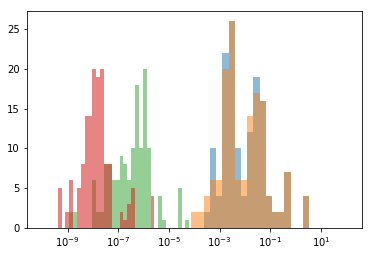

In [38]:
# Blue: XYG3 Hessian histogram
plt.hist(abs(hess_xyg3).ravel(),
         bins=np.logspace(np.log10(1e-10),np.log10(100), 50), color='#1f77b480')
# Orange: MP2 Hessian histogram
plt.hist(abs(hess_mp2_gaussian).ravel(),
         bins=np.logspace(np.log10(1e-10),np.log10(100), 50), color='#ff7f0e80')

# Green: XYG3 analytic - numeric
plt.hist(abs(hess_xyg3 - hess_xyg3_num).ravel(),
         bins=np.logspace(np.log10(1e-10),np.log10(3e-3), 50), color='#2ca02c80')
# Red: MP2 Hessian histogram - numeric
plt.hist(abs(hess_mp2_gaussian - hess_mp2_pyscf_num).ravel(),
         bins=np.logspace(np.log10(1e-10),np.log10(3e-3), 50), color='#d6272890')

plt.gca().set_xscale("log")